# Self-Organizing Maps (SOMs) Notebook
## Data extraction step - Step 1

**Notebook by Maria J. Molina (NCAR) and Alice DuVivier (NCAR).**

**Still very much in progress**

This Notebook reads in data from the CESM2-LE for a user-specified variable. It subsets the data by a user-specified coastal region around Antarctica.

Before starting, make sure you went to https://github.com/NCAR/ncar-python-tutorial#step-2-install-miniconda-and-create-environments
and completed steps 1 through 3.

Also, make sure you activate your conda environment containing the packages needed for this work ``antarctica_som_env`` within the drop down menu located in the top right of this notebook.

In [17]:
# Needed imports

from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product

import intake
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask

In [2]:
# start up dask

cluster = NCARCluster(memory='100 GB')
cluster.scale(40) # number of workers requested
#cluster.adapt(1,80) # min and max
client = Client(cluster)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42001 instead
  expected, actual


import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.12.206.17:44798 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/42001/status,Cluster Workers: 8 Cores: 16 Memory: 200.00 GiB


### Set user-specified information

In [4]:
# set region of interest
# needed for plotting and choosing a mask
titles     = ['Ross Sea', 'Amundsen Bellingshausen Sea', 'Weddell Sea', 'Pacific Ocean', 'Indian Ocean']
shorts     = ['Ross', 'AMB', 'Wed', 'Pac', 'Ind']
masks      = ['Ross_mask', 'BAm_mask', 'Wed_mask', 'Pac_mask', 'Ind_mask']
lat_maxes  = [-72, -65, -65, -60, -60] 
lat_mins   = [-85, -85, -85, -80, -80]
lon_maxes  = [200, 300, 300, 90, 160] 
lon_mins   = [160, 220, 20, 20, 90]
lon_avgs   = [190, 260, 340, 55, 125]

In [5]:
# set s, which is the paired values above 
s = 0
sector_title = titles[s]
sector_short = shorts[s]
mask_in = masks[s]
lat_max = lat_maxes[s]
lat_min = lat_mins[s]
lon_max = lon_maxes[s]
lon_min = lon_mins[s]
lon_avg = lon_avgs[s]

## Section 1: Load and get correct training data

### Load in the data

In [6]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
# set some info for the CESM2-LE data
# set: variable to test, the location of the data, which ensemble member
var_in = 'aice_d'
 # do not want smbb data
forcing = 'cmip6'

In [8]:
subset = cat.search(variable=var_in, forcing_variant=forcing)

In [9]:
#subset
subset.df.head()

,component,stream,case,member_id,experiment,forcing_variant,control_branch_year,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment_id
0,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1281,r9i1281p1f1,historical,cmip6,1281,aice_d,1940-01-02,1950-01-01,19400102-19500101,ice area (aggregate),1,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,CESM2_historical_r9i1281p1f1
1,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1251,r9i1251p1f1,historical,cmip6,1251,aice_d,1910-01-02,1920-01-01,19100102-19200101,ice area (aggregate),1,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,CESM2_historical_r9i1251p1f1
2,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1251,r5i1251p1f1,historical,cmip6,1251,aice_d,1890-01-02,1900-01-01,18900102-19000101,ice area (aggregate),1,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,CESM2_historical_r5i1251p1f1
3,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1251,r2i1251p1f1,historical,cmip6,1251,aice_d,2000-01-02,2010-01-01,20000102-20100101,ice area (aggregate),1,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,CESM2_historical_r2i1251p1f1
4,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1231,r8i1231p1f1,historical,cmip6,1231,aice_d,1860-01-02,1870-01-01,18600102-18700101,ice area (aggregate),1,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,CESM2_historical_r8i1231p1f1


In [10]:
# make arrays of half (25) of the CESM2-LE members 
# select every other from the large ensemble of both macro and micro starts
# note that the naming of the files (YYYY.#### e.g. 1001.001) doesn't match the member_id directly, 
# but the ensemble number (### e.g. 001) does match the member_id field r? directly. So use this to search

# set list of members from the dataset
member_ids = subset.df.member_id.unique()

# set list of members to KEEP
keep_list = ['r1i', 'r3i', 'r5i','r7i', 'r9i']


In [11]:
member_keep = [] # make a list to fill

for member in keep_list:
    for member_id in member_ids:
        if member in member_id:
            member_keep.append(member_id)

In [12]:
#check that we're keeping the right ones
member_keep

['r1i1281p1f1',
 'r1i1251p1f1',
 'r1i1231p1f1',
 'r1i1301p1f1',
 'r1i1001p1f1',
 'r3i1301p1f1',
 'r3i1231p1f1',
 'r3i1281p1f1',
 'r3i1251p1f1',
 'r3i1041p1f1',
 'r5i1251p1f1',
 'r5i1301p1f1',
 'r5i1081p1f1',
 'r5i1231p1f1',
 'r5i1281p1f1',
 'r7i1281p1f1',
 'r7i1121p1f1',
 'r7i1231p1f1',
 'r7i1251p1f1',
 'r7i1301p1f1',
 'r9i1281p1f1',
 'r9i1251p1f1',
 'r9i1231p1f1',
 'r9i1161p1f1',
 'r9i1301p1f1']

In [13]:
# now reduce subset based on just the members to keep
subset = subset.search(member_id=member_keep)

In [18]:
%%time
#actually load the data we selected into a dataset
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.control_branch_year.variable'


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
/glade/work/duvivier/minicon

CPU times: user 26.4 s, sys: 730 ms, total: 27.1 s
Wall time: 32.5 s


In [19]:
# print names of the dataset keys, which refer to each of the ensembles loaded
dsets.keys()

dict_keys(['ice.ssp370.cice.h1.cmip6.1041.aice_d', 'ice.historical.cice.h1.cmip6.1281.aice_d', 'ice.ssp370.cice.h1.cmip6.1121.aice_d', 'ice.ssp370.cice.h1.cmip6.1301.aice_d', 'ice.ssp370.cice.h1.cmip6.1161.aice_d', 'ice.historical.cice.h1.cmip6.1301.aice_d', 'ice.ssp370.cice.h1.cmip6.1251.aice_d', 'ice.ssp370.cice.h1.cmip6.1281.aice_d', 'ice.ssp370.cice.h1.cmip6.1001.aice_d', 'ice.ssp370.cice.h1.cmip6.1231.aice_d', 'ice.historical.cice.h1.cmip6.1121.aice_d', 'ice.ssp370.cice.h1.cmip6.1081.aice_d', 'ice.historical.cice.h1.cmip6.1251.aice_d', 'ice.historical.cice.h1.cmip6.1081.aice_d', 'ice.historical.cice.h1.cmip6.1041.aice_d', 'ice.historical.cice.h1.cmip6.1001.aice_d', 'ice.historical.cice.h1.cmip6.1161.aice_d', 'ice.historical.cice.h1.cmip6.1231.aice_d'])

In [20]:
# Look at just one dataset key to see what it looks like. 
# Note that for 1001 there is one member_id, but for 1231 there are 5 member_ids
# these refer to the individual ensemble members!

#dsets['ice.historical.cice.h1.cmip6.1001.aice_d']
dsets['ice.historical.cice.h1.cmip6.1231.aice_d']

<xarray.Dataset>
Dimensions:      (d2: 2, member_id: 5, nc: 5, ni: 320, nj: 384, nkbio: 5, nkice: 8, nksnow: 3, nvertices: 4, time: 60225)
Coordinates:
  * time         (time) object 1850-01-02 00:00:00 ... 2015-01-01 00:00:00
    TLON         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id    (member_id) <U11 'r1i1231p1f1' 'r3i1231p1f1' ... 'r9i1231p1f1'
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
Data variables:
    NCAT         (nc) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    VGRDi        (nkice) float32 dask.array<chunksize=(8,), meta=np.ndarray>
    VGRDs        (nksnow) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    VGRDb        (nkbio) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    tmask        (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    tarea        (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    uarea        (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dxt          (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dyt          (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dxu          (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dyu          (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    HTN          (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    HTE          (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ANGLE        (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ANGLET       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lont_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    latt_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lonu_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    latu_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    time_bounds  (time, d2) object dask.array<chunksize=(240, 2), meta=np.ndarray>
    aice_d       (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 240, 384, 320), meta=np.ndarray>
Attributes:
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    conventions:             CF-1.0
    contents:                Diagnostic and Prognostic Variables
    io_flavor:               io_pio
    time_period_freq:        day_1
    comment:                 All years have exactly 365 days
    intake_esm_varname:      ['aice_d']
    comment2:                File written on model date 18900102
    history:                 This dataset was created on 2020-03-14 at 07:57\...
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    comment3:                seconds elapsed into model date:      0
    title:                   b.e21.BHISTcmip6.f09_g17.LE2-1231.009
    intake_esm_dataset_key:  ice.historical.cice.h1.cmip6.1231.aice_d

In [21]:
# load in the historical and future datasets

historicals = []
futures = []

for key in sorted(dsets.keys()):
    if 'historical' in key:
        historicals.append(dsets[key])
        print(key)
    elif 'ssp370' in key:
        futures.append(dsets[key])
        print(key)

ice.historical.cice.h1.cmip6.1001.aice_d
ice.historical.cice.h1.cmip6.1041.aice_d
ice.historical.cice.h1.cmip6.1081.aice_d
ice.historical.cice.h1.cmip6.1121.aice_d
ice.historical.cice.h1.cmip6.1161.aice_d
ice.historical.cice.h1.cmip6.1231.aice_d
ice.historical.cice.h1.cmip6.1251.aice_d
ice.historical.cice.h1.cmip6.1281.aice_d
ice.historical.cice.h1.cmip6.1301.aice_d
ice.ssp370.cice.h1.cmip6.1001.aice_d
ice.ssp370.cice.h1.cmip6.1041.aice_d
ice.ssp370.cice.h1.cmip6.1081.aice_d
ice.ssp370.cice.h1.cmip6.1121.aice_d
ice.ssp370.cice.h1.cmip6.1161.aice_d
ice.ssp370.cice.h1.cmip6.1231.aice_d
ice.ssp370.cice.h1.cmip6.1251.aice_d
ice.ssp370.cice.h1.cmip6.1281.aice_d
ice.ssp370.cice.h1.cmip6.1301.aice_d


In [22]:
# Now put these into an array by member_id
historical_ds = xr.concat(historicals, dim='member_id')
future_ds = xr.concat(futures, dim='member_id')

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


In [23]:
# note that the historical and future xarray datasets have the same coordinates and dimensions *except* time, 
# so we need to concatenate over time
ds_ice = xr.concat([historical_ds,future_ds],dim='time')

In [24]:
ds_ice

<xarray.Dataset>
Dimensions:      (d2: 2, member_id: 25, nc: 5, ni: 320, nj: 384, nkbio: 5, nkice: 8, nksnow: 3, nvertices: 4, time: 91615)
Coordinates:
  * time         (time) object 1850-01-02 00:00:00 ... 2101-01-01 00:00:00
    TLON         (nj, ni) float32 320.5625 321.6875 322.8125 ... nan nan nan
    TLAT         (nj, ni) float32 -79.22052 -79.22052 -79.22052 ... nan nan nan
    ULON         (nj, ni) float32 321.125 322.25 323.375 324.5 ... nan nan nan
    ULAT         (nj, ni) float32 -78.952896 -78.952896 -78.952896 ... nan nan
  * member_id    (member_id) object 'r1i1001p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
Data variables:
    NCAT         (time, member_id, nc) float32 dask.array<chunksize=(60225, 1, 5), meta=np.ndarray>
    VGRDi        (time, member_id, nkice) float32 dask.array<chunksize=(60225, 1, 8), meta=np.ndarray>
    VGRDs        (time, member_id, nksnow) float32 dask.array<chunksize=(60225, 1, 3), meta=np.ndarray>
    VGRDb        (time, member_id, nkbio) float32 dask.array<chunksize=(60225, 1, 5), meta=np.ndarray>
    tmask        (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 1, 384, 320), meta=np.ndarray>
    tarea        (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 1, 384, 320), meta=np.ndarray>
    uarea        (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 1, 384, 320), meta=np.ndarray>
    dxt          (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 1, 384, 320), meta=np.ndarray>
    dyt          (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 1, 384, 320), meta=np.ndarray>
    dxu          (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 1, 384, 320), meta=np.ndarray>
    dyu          (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 1, 384, 320), meta=np.ndarray>
    HTN          (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 1, 384, 320), meta=np.ndarray>
    HTE          (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 1, 384, 320), meta=np.ndarray>
    ANGLE        (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 1, 384, 320), meta=np.ndarray>
    ANGLET       (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 1, 384, 320), meta=np.ndarray>
    lont_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 1, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 1, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 1, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 1, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 240, 2), meta=np.ndarray>
    aice_d       (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 240, 384, 320), meta=np.ndarray>
Attributes:
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    conventions:             CF-1.0
    contents:                Diagnostic and Prognostic Variables
    io_flavor:               io_pio
    time_period_freq:        day_1
    comment:                 All years have exactly 365 days
    intake_esm_varname:      ['aice_d']
    comment2:                File written on model date 18500102
    history:                 This dataset was created on 2020-02-12 at 13:57\...
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    title:                   b.e21.BHISTcmip6.f09_g17.LE2-1001.001
    comment3:                seconds elapsed into model date:      0
    intake_esm_dataset_key:  ice.historical.cice.h1.cmip6.1001.aice_d

In [25]:
# we need to shift time by 1 day because of weird CESM conventions
ds_ice = ds_ice.assign_coords(time=ds_ice.coords["time"]-timedelta(days=1))

In [26]:
# keep just years greater than 1950 and less than 2050 (should do 2100??)
yy_st = "1950"
yy_ed = "2050"
ds_ice = ds_ice.sel(time=slice(yy_st, yy_ed))

In [27]:
ds_ice.time.dt.month

<xarray.DataArray 'month' (time: 36865)>
array([ 1,  1,  1, ..., 12, 12, 12])
Coordinates:
  * time     (time) object 1950-01-01 00:00:00 ... 2050-12-31 00:00:00

In [28]:
# Use .groupby('time.month') to organize the data into months
# then use .groups to extract the indices for each month
month_idxs=ds_ice.groupby('time.month').groups

# Extract the time indices corresponding to winter (SH: all times between April through September)
mm_st = 4
mm_ed = 10   # note that this is sept+1 because we want to get all the way through sept.

winter_indexes = []
for month in range(mm_st, mm_ed):
    winter_indexes+=month_idxs[month]
    
# Extract the winter months by selecting
# the relevant indices
ds_ice_winter=ds_ice.isel(time=winter_indexes)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [29]:
ds_ice_winter
#ds_ice_winter.shape

<xarray.Dataset>
Dimensions:      (d2: 2, member_id: 25, nc: 5, ni: 320, nj: 384, nkbio: 5, nkice: 8, nksnow: 3, nvertices: 4, time: 18483)
Coordinates:
  * time         (time) object 1950-04-01 00:00:00 ... 2050-09-30 00:00:00
    TLON         (nj, ni) float32 320.5625 321.6875 322.8125 ... nan nan nan
    TLAT         (nj, ni) float32 -79.22052 -79.22052 -79.22052 ... nan nan nan
    ULON         (nj, ni) float32 321.125 322.25 323.375 324.5 ... nan nan nan
    ULAT         (nj, ni) float32 -78.952896 -78.952896 -78.952896 ... nan nan
  * member_id    (member_id) object 'r1i1001p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
Data variables:
    NCAT         (time, member_id, nc) float32 dask.array<chunksize=(1950, 1, 5), meta=np.ndarray>
    VGRDi        (time, member_id, nkice) float32 dask.array<chunksize=(1950, 1, 8), meta=np.ndarray>
    VGRDs        (time, member_id, nksnow) float32 dask.array<chunksize=(1950, 1, 3), meta=np.ndarray>
    VGRDb        (time, member_id, nkbio) float32 dask.array<chunksize=(1950, 1, 5), meta=np.ndarray>
    tmask        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    tarea        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    uarea        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dxt          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dyt          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dxu          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dyu          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    HTN          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    HTE          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    ANGLE        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    ANGLET       (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    lont_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 30, 2), meta=np.ndarray>
    aice_d       (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 30, 384, 320), meta=np.ndarray>
Attributes:
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    conventions:             CF-1.0
    contents:                Diagnostic and Prognostic Variables
    io_flavor:               io_pio
    time_period_freq:        day_1
    comment:                 All years have exactly 365 days
    intake_esm_varname:      ['aice_d']
    comment2:                File written on model date 18500102
    history:                 This dataset was created on 2020-02-12 at 13:57\...
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    title:                   b.e21.BHISTcmip6.f09_g17.LE2-1001.001
    comment3:                seconds elapsed into model date:      0
    intake_esm_dataset_key:  ice.historical.cice.h1.cmip6.1001.aice_d

In [30]:
# want to compute everything up to here and then keep the results in memory 
ds_ice_winter = ds_ice_winter.persist()

In [31]:
ds_ice_winter

<xarray.Dataset>
Dimensions:      (d2: 2, member_id: 25, nc: 5, ni: 320, nj: 384, nkbio: 5, nkice: 8, nksnow: 3, nvertices: 4, time: 18483)
Coordinates:
  * time         (time) object 1950-04-01 00:00:00 ... 2050-09-30 00:00:00
    TLON         (nj, ni) float32 320.5625 321.6875 322.8125 ... nan nan nan
    TLAT         (nj, ni) float32 -79.22052 -79.22052 -79.22052 ... nan nan nan
    ULON         (nj, ni) float32 321.125 322.25 323.375 324.5 ... nan nan nan
    ULAT         (nj, ni) float32 -78.952896 -78.952896 -78.952896 ... nan nan
  * member_id    (member_id) object 'r1i1001p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
Data variables:
    NCAT         (time, member_id, nc) float32 dask.array<chunksize=(1950, 1, 5), meta=np.ndarray>
    VGRDi        (time, member_id, nkice) float32 dask.array<chunksize=(1950, 1, 8), meta=np.ndarray>
    VGRDs        (time, member_id, nksnow) float32 dask.array<chunksize=(1950, 1, 3), meta=np.ndarray>
    VGRDb        (time, member_id, nkbio) float32 dask.array<chunksize=(1950, 1, 5), meta=np.ndarray>
    tmask        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    tarea        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    uarea        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dxt          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dyt          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dxu          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dyu          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    HTN          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    HTE          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    ANGLE        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    ANGLET       (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    lont_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 30, 2), meta=np.ndarray>
    aice_d       (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 30, 384, 320), meta=np.ndarray>
Attributes:
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    conventions:             CF-1.0
    contents:                Diagnostic and Prognostic Variables
    io_flavor:               io_pio
    time_period_freq:        day_1
    comment:                 All years have exactly 365 days
    intake_esm_varname:      ['aice_d']
    comment2:                File written on model date 18500102
    history:                 This dataset was created on 2020-02-12 at 13:57\...
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    title:                   b.e21.BHISTcmip6.f09_g17.LE2-1001.001
    comment3:                seconds elapsed into model date:      0
    intake_esm_dataset_key:  ice.historical.cice.h1.cmip6.1001.aice_d

### Mask data

In [32]:
# Load in the masking file
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/DATA/masks/antarctic_ocean_masks_2.nc')

# need to use the intersection of masks for a particular sector (e.g. Ross_mask) with the coastal mask (coast_mask)
# create array for mask
ds_mask = xr.where((ds_masks[mask_in]==1)&(ds_masks['coast_mask']==1),ds_masks['coast_mask'],0)

# rename the coordinates for the mask
ds_mask=ds_mask.rename({'nlat':'nj','nlon': 'ni'})

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sh_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'socn_mask' has multiple fill values {0, -2147483647}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'Wed_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'Ross_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  de

In [33]:
ds_ice_winter

<xarray.Dataset>
Dimensions:      (d2: 2, member_id: 25, nc: 5, ni: 320, nj: 384, nkbio: 5, nkice: 8, nksnow: 3, nvertices: 4, time: 18483)
Coordinates:
  * time         (time) object 1950-04-01 00:00:00 ... 2050-09-30 00:00:00
    TLON         (nj, ni) float32 320.5625 321.6875 322.8125 ... nan nan nan
    TLAT         (nj, ni) float32 -79.22052 -79.22052 -79.22052 ... nan nan nan
    ULON         (nj, ni) float32 321.125 322.25 323.375 324.5 ... nan nan nan
    ULAT         (nj, ni) float32 -78.952896 -78.952896 -78.952896 ... nan nan
  * member_id    (member_id) object 'r1i1001p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
Data variables:
    NCAT         (time, member_id, nc) float32 dask.array<chunksize=(1950, 1, 5), meta=np.ndarray>
    VGRDi        (time, member_id, nkice) float32 dask.array<chunksize=(1950, 1, 8), meta=np.ndarray>
    VGRDs        (time, member_id, nksnow) float32 dask.array<chunksize=(1950, 1, 3), meta=np.ndarray>
    VGRDb        (time, member_id, nkbio) float32 dask.array<chunksize=(1950, 1, 5), meta=np.ndarray>
    tmask        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    tarea        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    uarea        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dxt          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dyt          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dxu          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    dyu          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    HTN          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    HTE          (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    ANGLE        (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    ANGLET       (time, member_id, nj, ni) float32 dask.array<chunksize=(1950, 1, 384, 320), meta=np.ndarray>
    lont_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(1950, 1, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 30, 2), meta=np.ndarray>
    aice_d       (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 30, 384, 320), meta=np.ndarray>
Attributes:
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    conventions:             CF-1.0
    contents:                Diagnostic and Prognostic Variables
    io_flavor:               io_pio
    time_period_freq:        day_1
    comment:                 All years have exactly 365 days
    intake_esm_varname:      ['aice_d']
    comment2:                File written on model date 18500102
    history:                 This dataset was created on 2020-02-12 at 13:57\...
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    title:                   b.e21.BHISTcmip6.f09_g17.LE2-1001.001
    comment3:                seconds elapsed into model date:      0
    intake_esm_dataset_key:  ice.historical.cice.h1.cmip6.1001.aice_d

In [34]:
ds_ice_masked = ds_ice_winter[var_in]*ds_mask

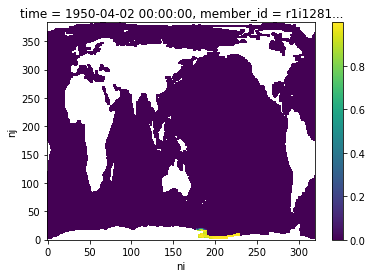

In [35]:
#just test that it worked properly - Should only be coastal data in region of interest!!
ds_ice_masked.sel(member_id='r1i1281p1f1').isel(time=1).plot()

In [36]:
# make smaller array where we ignore all global data
# do a subset to make easier to plot
# not sure why the projection below seems happier when data is subset...

if sector_short == 'Wed':
    ds_ice_masked_subset = ds_ice_masked.where(
                             ((ds_ice_masked['TLAT']<lat_max) & (ds_ice_masked['TLAT']>lat_min)) &\
                             ((ds_ice_masked['TLON']<lon_min) | (ds_ice_masked['TLON']>lon_max)),
                             drop=True)  
else:
    
    ds_ice_masked_subset = ds_ice_masked.where(
                             (ds_ice_masked['TLAT']<lat_max) & (ds_ice_masked['TLAT']>lat_min) & \
                             (ds_ice_masked['TLON']>lon_min) & (ds_ice_masked['TLON']<lon_max), 
                             drop=True) 
    
# For Weddell Sea only:
# to accurately plot the strip of ice along the coast, we need to subset the two regions and concatenate them

#if sector_short == 'Wed':
#    xr.concat([ds_ice_masked_subset.isel(time=0).isel(ni=slice(53,72)),ds_ice_masked_subset.isel(time=0).isel(ni=slice(0,53))], dim='ni').plot()

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [ ]:
# Want to check that we're plotting the correct area for the training data
# using pcolor here

# Choose just one timestep
data = ds_ice_masked_subset.sel(member_id='r1i1281p1f1').isel(time=1000)

fig = plt.figure(figsize=(12,9))

ax = plt.axes([0.,0.,1.,1.], projection=ccrs.SouthPolarStereo(central_longitude=0))

ax.set_title(sector_title +' '+var_in, fontsize=12)

# add cyclic point -- doesnt work due to nans
#data_, lons_ = add_cyclic_point(data, coord=np.array(lon_new))

# doing scatter instead for now
cs1 = ax.scatter(     data.coords['TLON'].values,    
                     data.coords['TLAT'].values, 
                     data, cmap='Blues',
                vmin=0,vmax=5,
                #vmin=-10,vmax=0,
                     transform=ccrs.PlateCarree())

ax.set_extent([lon_min,lon_max,lat_min,lat_max+10], ccrs.PlateCarree())

############################################
# Cartopy coastline and the land feature dont match perfectly for antarctica!
# maybe just use one of them? i dont know which one is more accurate for your data 

ax.coastlines(resolution='110m', color='0.25', linewidth=0.5, zorder=10)  

#ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')

############################################

ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)

#plt.colorbar(cs1)

#plt.savefig(sector_short+'_'+var_in+'_1.png', bbox_inches='tight', dpi=200)

plt.show()

In [37]:
ds_ice_masked

,Array,Chunk
Bytes,211.52 GiB,14.53 MiB
Shape,"(25, 18483, 384, 320)","(1, 31, 384, 320)"
Count,34459 Tasks,17225 Chunks
Type,float32,numpy.ndarray


In [ ]:
temp1 = ds_ice_masked.stack(horiz=("nj","ni"))

In [41]:
temp1

,Array,Chunk
Bytes,211.52 GiB,14.53 MiB
Shape,"(25, 18483, 122880)","(1, 31, 122880)"
Count,51684 Tasks,17225 Chunks
Type,float32,numpy.ndarray


In [ ]:
temp2 = temp1.stack(new=("member_id","time"))

In [ ]:
temp2

In [38]:
# Flatten into this new shape * prior * to dropping values. otherwise, xarray fills 
# values with NaNs (or other value) to return a 2d shape, which we don't want.
# Note that we want time and member_id to be combined into a single dimension giving us 
# nens*ntime (25*18483 = 462075) total training inputs, and each will have length (nj*ni).

# stack just the horizontal points
temp1 = ds_ice_masked.stack(horiz=("nj","ni"))

# Ok, now stack member_id with time
temp2 = temp1.stack(new=("member_id","time"))

In [39]:
temp2

<xarray.DataArray (horiz: 122880, new: 462075)>
dask.array<reshape, shape=(122880, 462075), dtype=float32, chunksize=(122880, 18483), chunktype=numpy.ndarray>
Coordinates:
    TLON       (horiz) float32 320.5625 321.6875 322.8125 ... nan nan nan
    TLAT       (horiz) float32 -79.22052 -79.22052 -79.22052 ... nan nan nan
    ULON       (horiz) float32 321.125 322.25 323.375 324.5 ... nan nan nan nan
    ULAT       (horiz) float32 -78.952896 -78.952896 -78.952896 ... nan nan nan
  * horiz      (horiz) MultiIndex
  - nj         (horiz) int64 0 0 0 0 0 0 0 0 ... 383 383 383 383 383 383 383 383
  - ni         (horiz) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
  * new        (new) MultiIndex
  - member_id  (new) object 'r1i1001p1f1' 'r1i1001p1f1' ... 'r9i1301p1f1'
  - time       (new) object 1950-04-01 00:00:00 ... 2050-09-30 00:00:00

In [40]:
# assign object a name (e.g., subset) and drop the data we don't need to minimize size of the array
training_subset = temp2.where(temp2!=-999.999, drop=True)


KilledWorker: ('open_dataset-87adbf06f4eb639dca4aacf040480c8caice_d-748a2108a102023112642e45cd7ca42d', <WorkerState 'tcp://10.12.206.13:35713', name: PBSCluster-26, memory: 0, processing: 97>)

In [ ]:
training_subset

In [ ]:
# assign to numpy array object
subsetarray = subset.values

In [ ]:
subset

In [ ]:
## HAD TO STOP HERE 

In [ ]:
%%time
# THIS STEP IS A SLOW ONE
# Flatten into this new shape * prior * to dropping values. otherwise, xarray fills 
# values with NaNs (or other value) to return a 2d shape, which we don't want.
ds_ice_masked_1d = ds_ice_masked.stack(new=("nj","ni"))

# assign object a name (e.g., subset) and drop the data we don't need to minimize size of the array
subset = ds_ice_masked_1d.where(ds_ice_masked_1d!=-999.999, drop=True)

# assign to numpy array object
subsetarray = subset.values

In [ ]:
subset

In [ ]:
# triple check the data dims/shape
print(subsetarray.shape)
# confirm there are no NaN values in array for training (should print False if no values)
print(np.isnan(subsetarray).any())

### Saving data processed to intermediary file that will be opened in the next nb 

``soms_antarctica-training``

In [ ]:
ds_to_save = xr.Dataset({'train_data': (['time','points'], subsetarray)}, 
                        coords={'time':(['time'],subset.time.values),
                                'TLON':(['points'],subset.TLON.values),
                                'TLAT':(['points'],subset.TLAT.values),
                                'nj':(['points'],subset.nj.values),
                                'ni':(['points'],subset.ni.values)},
                        attrs={'Author': 'Alice DuVivier'})

# SHOULD WE SAVE THE ENS MEMBER SOMEHOW?
# WILL NEED THIS TO MAKE A COMPOSITE

In [ ]:
ds_to_save

In [ ]:
ds_to_save.to_netcdf('training_data_region_'+sector_short+'_'+var_in+'.nc')  # how to save file